<a href="https://colab.research.google.com/github/Goro-python/my_NLP/blob/next_dev/Android_autofill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Uploading the Data 

from google.colab import files
upload = files.upload()


Saving modelling_data_ver2.csv to modelling_data_ver2.csv


In [3]:
!ls

modelling_data_ver2.csv  sample_data


In [1]:
!ls

sample_data


In [4]:
!pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4MB 47kB/s 
     |████████████████████████████████| 460kB 45.8MB/s 
     |████████████████████████████████| 20.1MB 46.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [1]:
# modelling with BERT 
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
tf.__version__

'2.3.0'

In [3]:
!pip install transformers


     |████████████████████████████████| 2.0MB 8.9MB/s 
     |████████████████████████████████| 3.3MB 40.7MB/s 
     |████████████████████████████████| 870kB 45.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=de6305249af6c3140f6d395f0b394721a51bbc328197335feff69829d78127f7
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [4]:
df['X'].sample(10)

NameError: ignored

In [4]:
df = pd.read_csv("modelling_data_ver2.csv")

In [61]:
maxLength = 0
minLength = float('inf')
for sent in df['X']:
    maxLength = max(maxLength,len(sent))
    minLength = min(minLength,len(sent))
    
print("Maximum Sentence length: ", maxLength )
print("Minimum Sentence length: ", minLength)

Maximum Sentence length:  300
Minimum Sentence length:  25


In [62]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [63]:
label = df.MacroField.values
sentences = df.X.values

In [64]:
# Print the original sentence.
# testing sentence
np.random.seed(3)
index = np.random.randint(7552)
sentence = sentences[index]
print(' Original: ', sentence)

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentence))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)))

 Original:  2 missing missing missing verify edit number
Tokenized:  ['2', 'missing', 'missing', 'missing', 'verify', 'edit', 'number']
Token IDs:  [1016, 4394, 4394, 4394, 20410, 10086, 2193]


In [65]:
# train and test split dataset
from sklearn.model_selection import train_test_split
train_sent,test_sent,train_label,test_label = train_test_split(sentences,label,test_size = 0.15)

In [66]:
print("Training Size:",train_sent.shape[0])
print("Test Size:",test_sent.shape[0])

Training Size: 6393
Test Size: 1129


In [67]:
# lets convertt the sentences to Ids
max_length = 300
encoded = tokenizer.batch_encode_plus(
            train_sent,
            padding = 'longest',
        )
input_ids = np.array(encoded["input_ids"],dtype = "int32")
att_mask =  np.array(encoded["attention_mask"],dtype="int32")

In [68]:
input_ids.shape

(6393, 67)

In [69]:
maxLength = att_mask.shape[1]

In [70]:
from transformers import TFBertModel
np.random.seed(4)
max_length = maxLength

def createModel():
  """ create the model for Android Form Fill with BERT Tokenizer """
  input_ids = tf.keras.layers.Input(
          shape=(max_length,), dtype=tf.int32, name="input_ids")
      # Attention masks indicates to the model which tokens should be attended to.
  attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")
      # Token type ids are binary masks identifying different sequences in the model.
  bert_model = TFBertModel.from_pretrained("bert-base-uncased")
      # Freeze the BERT model to reuse the pretrained features without modifying them.
  bert_model.trainable = False
  bert_out = bert_model(input_ids, attention_mask=attention_masks)
  print(bert_out)
  sequence_output = bert_out["last_hidden_state"]
  print(sequence_output)
  # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
  bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
      # Applying hybrid pooling approach to bi_lstm sequence output.
  avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
  max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
  concat = tf.keras.layers.concatenate([avg_pool, max_pool])
  dropout = tf.keras.layers.Dropout(0.3)(concat)
  output = tf.keras.layers.Dense(4, activation="softmax")(dropout)
  model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
  model.compile(optimizer=tf.keras.optimizers.Adam(),
          loss= "sparse_categorical_crossentropy",
          metrics=["accuracy"],run_eagerly= True)

  model.summary()
  return model

In [71]:
Android_autofill_bert = createModel()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


TFBaseModelOutputWithPooling(last_hidden_state=<tf.Tensor 'tf_bert_model_4/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0' shape=(None, 67, 768) dtype=float32>, pooler_output=<tf.Tensor 'tf_bert_model_4/bert/pooler/dense/Tanh:0' shape=(None, 768) dtype=float32>, hidden_states=None, attentions=None)
Tensor("tf_bert_model_4/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0", shape=(None, 67, 768), dtype=float32)
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 67)]         0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 67)]         0                                            
________________________________________________

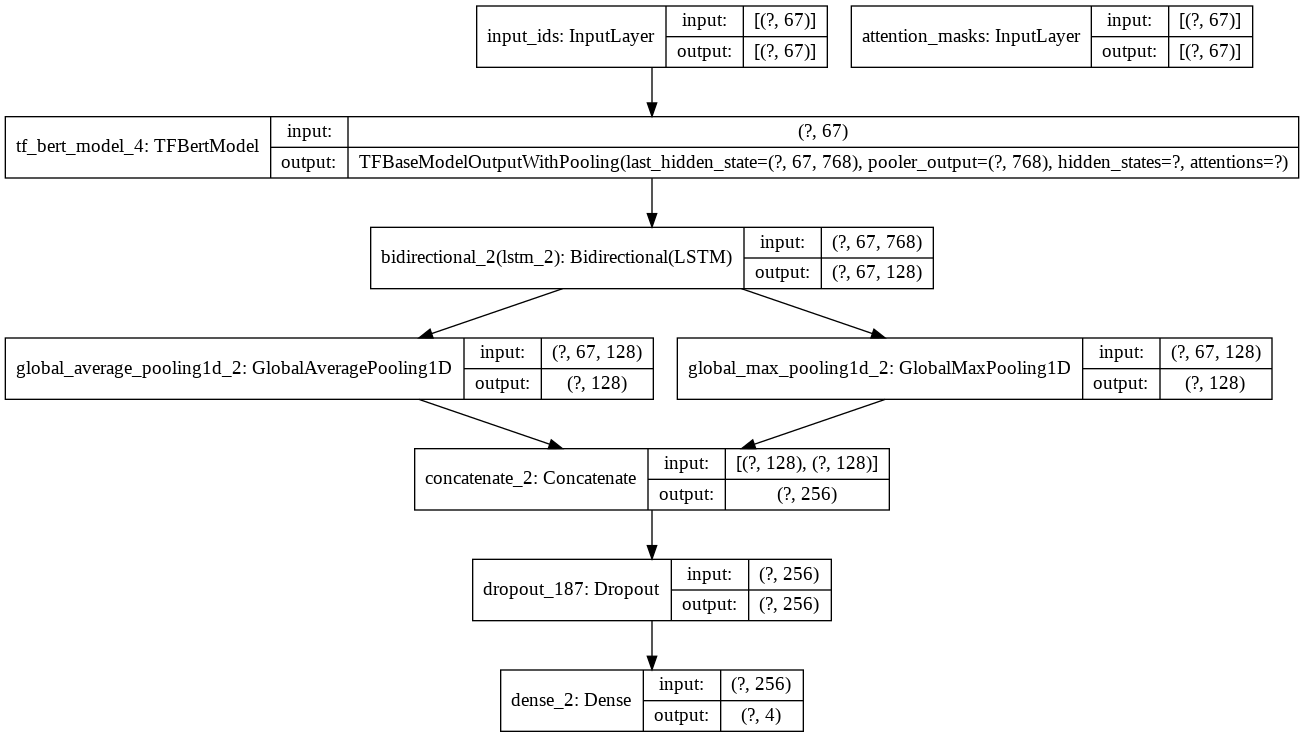

In [72]:
tf.keras.utils.plot_model(Android_autofill_bert,show_shapes=True)

In [73]:
#getting the test data ready
max_length = maxLength
encoded = tokenizer.batch_encode_plus(
            test_sent,
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True)


test_input_ids = np.array(encoded["input_ids"],dtype = "int32")
test_att_mask =  np.array(encoded["attention_mask"],dtype="int32")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [74]:
test_att_mask.shape

(1129, 67)

In [77]:
#traing and testing  the model iteratively
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience= 2)
model_hist =   Android_autofill_bert.fit(x = [input_ids,att_mask], y = train_label, batch_size = 32,  epochs = 2, validation_data = ([test_input_ids,test_att_mask],test_label),callbacks = [early_stopping])

Epoch 1/2
200/200 [==============================] - 186s 930ms/step - loss: 0.5373 - accuracy: 0.8189 - val_loss: 0.4593 - val_accuracy: 0.8530
Epoch 2/2
200/200 [==============================] - 186s 928ms/step - loss: 0.4606 - accuracy: 0.8464 - val_loss: 0.4502 - val_accuracy: 0.8530


In [78]:
# Precison and recall for each class 
y_test = test_label
y_pred =  Android_autofill_bert.predict([test_input_ids,test_att_mask])

In [83]:
# confusion matrix
macroLabel = []
macroLabel = [np.argmax(pred) for pred in y_pred]

In [86]:
y_test

array([3, 3, 0, ..., 2, 3, 0])

In [89]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, macroLabel)

array([[468,   0,   3,  60],
       [ 18,   0,   3,  26],
       [  9,   0,  56,  23],
       [ 21,   0,   3, 439]])

In [97]:
# get the RoC , Precision and Recall
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
print("precision Score :")
precision_score(y_test,macroLabel, average='macro')

precision Score :


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6424025240588642

In [95]:
print("Recall Score :")
recall_score(y_test,macroLabel,average='macro')

Recall Score :


0.6164709288588192

In [98]:
print("f1 score ")
f1_score(y_test,macroLabel,average = "macro")

f1 score 


0.6236140084776765

In [24]:
from sklearn.metrics import precision_recall_fscore_support
prec,rec,f1,support = precision_recall_fscore_support(y_test, macroLabel, average=None,labels=[0, 1, 2,3])

NameError: ignored

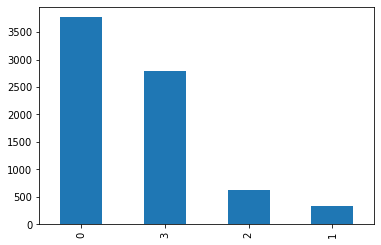

In [107]:
df['MacroField'].value_counts().plot.bar()

In [103]:
reca

0.6164709288588192

In [119]:
import time

In [131]:
%%timeit -r 3 -n 10
"the code you want to test stays here"
y_pred =  Android_autofill_bert.predict([test_input_ids[:1],test_att_mask[:1]])

10 loops, best of 3: 186 ms per loop


In [125]:
[test_input_ids[:2],test_att_mask[:2]]

[array([[ 101, 1016, 4394, 4394, 4394, 4923, 3477, 2951,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 2871, 4394, 2197, 2171, 4394, 4394,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], dtype=int32),
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

In [6]:
# smaller models 


df.sample(10)

,Unnamed: 0,Unnamed: 0.1,labelledField,inputType,contentDescription,hint,htmlInfo,idEntry,MacroField,X
6488,6488,6638,CREDIT_CARD_NUMBER,2,missing,missing,missing,credit card number text,2,2 missing missing missing credit card number text
4837,4837,4940,NAME_LAST,0,missing,last name,name lastname type text label last name auto f...,missing,3,0 missing last name name lastname type text la...
4733,4733,4836,USERNAME_OR_EMAIL_ADDRESS,58,missing,email,missing,email,0,58 missing email missing email
2673,2673,2721,IGNORE,3,missing,missing,missing,phone,1,3 missing missing missing phone
5791,5791,5912,PASSWORD,15,password edit text,password,missing,text input edit text,0,15 password edit text password missing text in...
5124,5124,5232,OTP,2,missing,missing,missing,code material edit text,0,2 missing missing missing code material edit text
6657,6657,6815,PASSWORD,0,missing,password,name password type password label password aut...,missing,0,0 missing password name password type password...
4936,4936,5044,PASSWORD,15,missing,password,missing,missing,0,15 missing password missing missing
1692,1692,1735,OTP,3,missing,missing,missing,missing,0,3 missing missing missing missing
2001,2001,2045,CVV_CVC,3,missing,cvc cvc four digits located front card right h...,missing,missing,2,3 missing cvc cvc four digits located front ca...


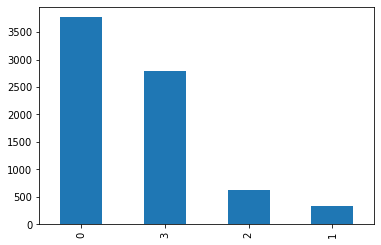

In [6]:
df['MacroField'].value_counts().plot.bar()

In [7]:
df_0 =  df[df['MacroField']==0]
df_1 =  df[df['MacroField']==1]
df_2 =  df[df['MacroField']==2]
df_3 =  df[df['MacroField']==3]

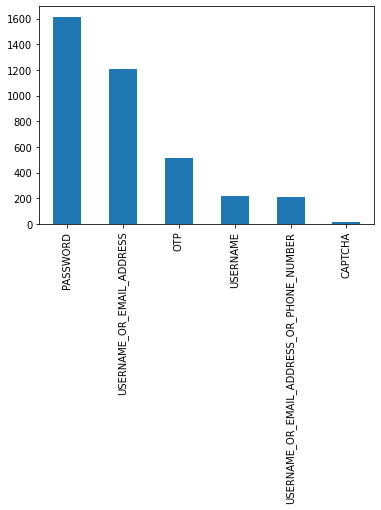

In [13]:
# Let's make it a model for "0"or "Credentials"
df_0[' labelledField'].value_counts().plot.bar()

In [14]:
# not required

In [19]:
# model for Credential 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_0[' labelledField'] = le.fit_transform(df_0[' labelledField'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


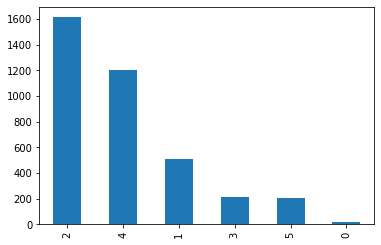

In [22]:
df_0[' labelledField'].value_counts().plot.bar()

In [28]:
df_0[' labelledField'].values

array([4, 2, 1, ..., 2, 1, 2])

In [30]:
label = df_0[' labelledField'].values
sentences = df_0.X.values

In [31]:
label.size

3767

In [32]:
sentences.shape

(3767,)

In [36]:
from sklearn.model_selection import train_test_split
cred_x_train,cred_x_test,cred_y_train,cred_y_test = train_test_split(sentences,label,test_size = 0.15)

In [41]:
cred_y_test.shape

(566,)

In [33]:
# convert to tokenizer
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [42]:
encoded_train = tokenizer.batch_encode_plus(
            cred_x_train,
            padding = 'longest',
        )


In [43]:
train_input_ids = np.array(encoded_train["input_ids"],dtype = "int32")
train_att_mask =  np.array(encoded_train["attention_mask"],dtype="int32")

In [46]:
maxLength = train_att_mask.shape[1]

In [48]:
# test data set up

max_length = maxLength
encoded_test = tokenizer.batch_encode_plus(
            cred_x_test,
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [49]:
# test data 

test_input_ids = np.array(encoded_test["input_ids"],dtype = "int32")
test_att_mask =  np.array(encoded_test["attention_mask"],dtype="int32")

In [51]:
from transformers import TFBertModel
np.random.seed(4)
max_length = maxLength

def createModel():
  """ create the model for Android Form Fill with BERT Tokenizer """
  input_ids = tf.keras.layers.Input(
          shape=(max_length,), dtype=tf.int32, name="input_ids")
      # Attention masks indicates to the model which tokens should be attended to.
  attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")
      # Token type ids are binary masks identifying different sequences in the model.
  bert_model = TFBertModel.from_pretrained("bert-base-uncased")
      # Freeze the BERT model to reuse the pretrained features without modifying them.
  bert_model.trainable = False
  bert_out = bert_model(input_ids, attention_mask=attention_masks)
  print(bert_out)
  sequence_output = bert_out["last_hidden_state"]
  print(sequence_output)
  # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
  bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
      # Applying hybrid pooling approach to bi_lstm sequence output.
  avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
  max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
  concat = tf.keras.layers.concatenate([avg_pool, max_pool])
  dropout = tf.keras.layers.Dropout(0.3)(concat)
  output = tf.keras.layers.Dense(6, activation="softmax")(dropout)
  model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
  model.compile(optimizer=tf.keras.optimizers.Adam(),
          loss= "sparse_categorical_crossentropy",
          metrics=["accuracy"],run_eagerly= True)

  model.summary()
  return model


In [52]:
cred_autofill_bert = createModel()


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [57]:
# Lets train the model
# sanity Check 
cred_y_test.shape

(566,)

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience= 2)
cred_model_hist =   cred_autofill_bert.fit(x = [train_input_ids,train_att_mask], y = cred_y_train, batch_size = 32,  epochs = 5, validation_data = ([test_input_ids,test_att_mask],cred_y_test),callbacks = [early_stopping])

Epoch 1/5
101/101 [==============================] - 47s 465ms/step - loss: 0.2921 - accuracy: 0.9078 - val_loss: 0.2350 - val_accuracy: 0.9223
Epoch 2/5
101/101 [==============================] - 47s 466ms/step - loss: 0.2884 - accuracy: 0.9085 - val_loss: 0.2376 - val_accuracy: 0.9240
Epoch 3/5
101/101 [==============================] - 47s 465ms/step - loss: 0.2654 - accuracy: 0.9200 - val_loss: 0.2205 - val_accuracy: 0.9223
Epoch 4/5
101/101 [==============================] - 47s 464ms/step - loss: 0.2509 - accuracy: 0.9244 - val_loss: 0.1945 - val_accuracy: 0.9346
Epoch 5/5
101/101 [==============================] - 47s 466ms/step - loss: 0.2300 - accuracy: 0.9275 - val_loss: 0.2140 - val_accuracy: 0.9258


In [60]:
# precison and recall
y_true =  cred_y_test
predicts =  cred_autofill_bert.predict([test_input_ids,test_att_mask])

macroLabel = []
y_pred = [np.argmax(pred) for pred in predicts]


In [67]:
list(y_true)[:10]

[2, 2, 4, 4, 2, 4, 1, 1, 2, 2]

In [70]:
y_pred[:10]

[2, 2, 4, 4, 2, 4, 1, 1, 2, 2]

In [71]:
from sklearn.metrics import precision_recall_fscore_support
prec,rec,f1,support = precision_recall_fscore_support(y_true, y_pred,average=None,labels=[0, 1, 2,3,4,5])

In [72]:
prec

array([1.        , 0.84722222, 0.99190283, 0.65714286, 0.93717277,
       0.75      ])

Text(0, 0.5, 'Precision')

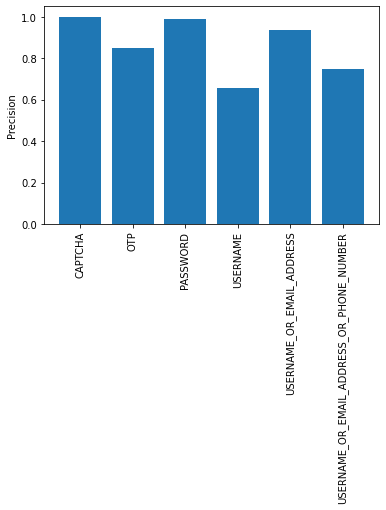

In [99]:
from matplotlib import pyplot as plt
plt.bar(x=le.inverse_transform([0, 1, 2,3,4,5]), height = prec)
plt.xticks(rotation = 90)
plt.ylabel("Precision")

Text(0, 0.5, 'Recall')

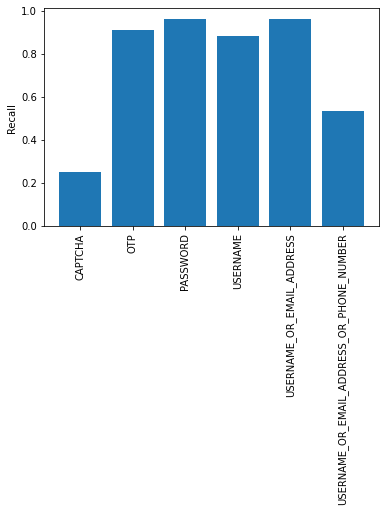

In [100]:
plt.bar(x=le.inverse_transform([0, 1, 2,3,4,5]), height = rec)
plt.xticks(rotation = 90)
plt.ylabel("Recall")


Text(0, 0.5, 'F1_core')

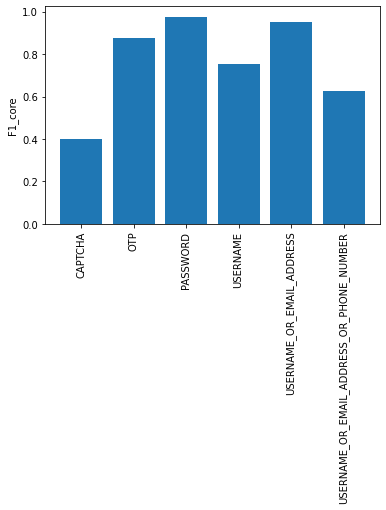

In [101]:
# f1 score 
plt.bar(x=le.inverse_transform([0, 1, 2,3,4,5]), height = f1)
plt.xticks(rotation = 90)
plt.ylabel("F1_core")

In [83]:
le.inverse_transform([0,1,2,3,4,5])

array(['CAPTCHA', 'OTP', 'PASSWORD', 'USERNAME',
       'USERNAME_OR_EMAIL_ADDRESS',
       'USERNAME_OR_EMAIL_ADDRESS_OR_PHONE_NUMBER'], dtype=object)

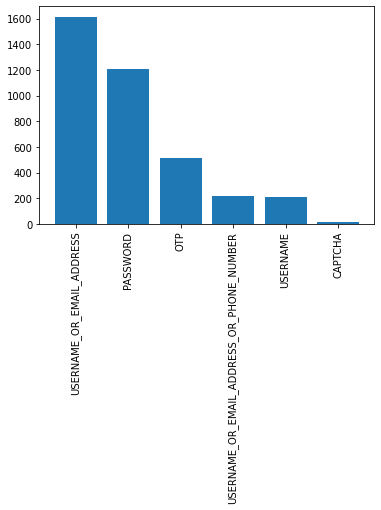

In [92]:
ax = plt.bar(x = le.inverse_transform(df_0[' labelledField'].unique()),height = df_0[' labelledField'].value_counts())
plt.xticks(rotation=90);

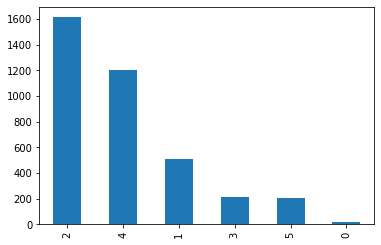

In [95]:
df_0[' labelledField'].value_counts().plot.bar()

In [98]:
le.inverse_transform([2,1,0,3,4,5])

array(['PASSWORD', 'OTP', 'CAPTCHA', 'USERNAME',
       'USERNAME_OR_EMAIL_ADDRESS',
       'USERNAME_OR_EMAIL_ADDRESS_OR_PHONE_NUMBER'], dtype=object)

In [102]:
from sklearn.metrics import matthews_corrcoef

In [103]:
 matthews_corrcoef(y_true,y_pred)

0.8902705703191903